Titanic Classification
=================

See [ShauryaBhandari/Kaggle-Titanic-Dataset](https://github.com/ShauryaBhandari/Kaggle-Titanic-Dataset)

see also
- https://medium.com/geekculture/applying-7-classification-algorithms-on-the-titanic-dataset-278ef222b53c
- https://eshitagoel.medium.com/eda-on-titanic-machine-learning-from-disaster-6b518bb97e17

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

from sklearn.model_selection import train_test_split

from pyautospec import parallel_plot, DatasetMps

train_df = pd.read_csv('./data/titanic_train.csv')
test_df  = pd.read_csv('./data/titanic_test.csv')

Drop Ticket and Cabin fields (they are not informative)

In [2]:
train_df = train_df.drop(['Ticket', 'Cabin', 'PassengerId'], axis=1)
test_df  = test_df.drop(['Ticket', 'Cabin', 'PassengerId'], axis=1)

Make sex field numeric

In [3]:
for df in [train_df, test_df]:
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)

Process title:

- extract the title from the passenger name
- group together old fashioned titles
- make numeric

In [4]:
for df in [train_df, test_df]:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for df in [train_df, test_df]:
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss').replace('Ms', 'Miss').replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for df in [train_df, test_df]:
    df['Title'] = df['Title'].map(title_mapping).fillna(0)

train_df = train_df.drop(['Name'], axis=1)
test_df  = test_df.drop(['Name'], axis=1)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


Replace missing ages with averages

In [5]:
guess_ages = np.zeros((2, 3))

for df in [train_df, test_df]:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = df[(df['Sex'] == i) & (df['Pclass'] == j + 1)]['Age'].dropna()

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i, j] = int(age_guess / 0.5 + 0.5) * 0.5

    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[(df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j + 1), 'Age'] = guess_ages[i, j]

    df['Age'] = df['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Replace age with age bands

In [6]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)

for df in [train_df, test_df]:
    df.loc[df['Age'] <= 16, 'Age'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
    df.loc[df['Age'] > 64, 'Age']

train_df = train_df.drop(['AgeBand'], axis=1)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


Add new field IsAlone

In [7]:
for df in [train_df, test_df]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

for df in [train_df, test_df]:
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df  = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)

Make embarked field numeric

In [8]:
for df in [train_df, test_df]:
    df['Age*Class'] = df.Age * df.Pclass
    
freq_port = train_df.Embarked.dropna().mode()[0]
for df in [train_df, test_df]:
    df['Embarked'] = df['Embarked'].fillna(freq_port)

for df in [train_df, test_df]:
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

Add missing fare with median and replace fare field with fare band

In [9]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

# Converting fare to ordinal values
for df in [train_df, test_df]:
    df.loc[df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare'] = 2
    df.loc[df['Fare'] > 31, 'Fare'] = 3
    df['Fare'] = df['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

At last prepare the datasets

In [10]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]

X_titanic_train, X_titanic_valid, y_titanic_train, y_titanic_valid = train_test_split(np.array(X_train), np.array(Y_train), test_size=0.2, random_state=42)

Train the model

In [11]:
titanic_mps = DatasetMps(8, x0=np.min(X_titanic_train, axis=0), x1=np.max(X_titanic_train, axis=0), max_bond_d=6, class_n=2)

titanic_mps.fit(X_titanic_train, y_titanic_train, X_titanic_valid, y_titanic_valid, learn_rate=0.01, batch_size=40, epochs = 60)

titanic_mps

  0%|          | 0/60 [00:00<?, ?it/s]

epoch   10: train 0.17 | valid 0.18
epoch   20: train 0.16 | valid 0.16
epoch   30: train 0.15 | valid 0.16
epoch   40: train 0.15 | valid 0.15
epoch   50: train 0.15 | valid 0.15
epoch   60: train 0.15 | valid 0.15


  DatasetMps

  ╭───┐ ╭───┐       ╭─┴─┐
  │ 1 ├─┤ 2 ├─ ... ─┤  8│
  └─┬─┘ └─┬─┘       └─┬─┘

  particle dim:   2
     class dim:   2
      bond dim:   6 (max: 6)
          type: classification
        

In [12]:
print("accuracy (train): {:.2f}%".format(100 * titanic_mps.score(X_titanic_train, y_titanic_train)))
print("accuracy (valid): {:.2f}%".format(100 * titanic_mps.score(X_titanic_valid, y_titanic_valid)))

accuracy (train): 82.02%
accuracy (valid): 82.68%


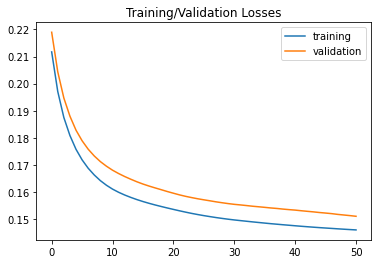

In [13]:
titanic_mps.model.training_chart()